In [1]:
import torch
from torch import nn
from fastai.torch_core import tensor, show_image
from fastai.data.core import DataLoader
from PIL import Image


In [2]:
from fastai.data.external import untar_data, URLs

path = untar_data(URLs.MNIST_SAMPLE)

def load_mnist(path):
    tens_stack = torch.stack([tensor(Image.open(o)) for o in path.ls()])
    return tens_stack.float()/255

# cubes ([num_images, 28, 28])
train_3_tens = load_mnist(path/'train'/'3')
train_7_tens = load_mnist(path/'train'/'7')

# matrices ([num_images, num_pixels_per_image])
train_x = torch.cat([train_3_tens, train_7_tens]).view(-1, 28*28)
train_y = tensor([1]*len(train_3_tens) + [0]*len(train_7_tens)).unsqueeze(1)
train_dset = list(zip(train_x, train_y))
train_dl = DataLoader(train_dset, batch_size=256)

valid_3_tens = load_mnist(path/'valid'/'3')
valid_7_tens = load_mnist(path/'valid'/'7')

valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))
valid_dl = DataLoader(valid_dset, batch_size=256)


In [3]:
# Common functions

lr = 1e-1

def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

def batch_accuracy(xb_preds, yb):
    xb_preds_norm = xb_preds.sigmoid()
    correct_vec = (xb_preds_norm>0.5) == yb
    return correct_vec.float().mean()

def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)


In [4]:
# Simple linear model

def init_values(size, std=1.0):
    return (torch.randn(size) * std).requires_grad_()

# def init_params():
#     torch.manual_seed(42)
#     weights = init_values((28 * 28, 1))
#     bias = init_values(1)
#     return weights, bias

def init_params():
    torch.manual_seed(42)
    linear_model = nn.Linear(28*28,1)
    weights, bias = linear_model.parameters()
    weights = weights.data.T.requires_grad_()  # Transpose to match our weights
    return weights, bias


params = init_params()
weights, bias = params

def linear1(xb):
    return xb @ weights + bias

def train_epoch(model, lr, params):
    for xb, yb in train_dl:
        calc_grad(xb, yb, model)
        for p in params:
            with torch.no_grad():
                p -= p.grad * lr
            p.grad.zero_()


print(validate_epoch(linear1), end=' ')

for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')


0.4883 0.5381 0.8701 0.9355 0.9536 0.9624 0.9633 0.9653 0.9657 0.9662 0.9677 0.9687 0.9701 0.9701 0.9701 0.9711 0.9716 0.9716 0.9716 0.9716 0.9721 

In [5]:
# organizing the code into a class, using pytorch's nn.Linear

torch.manual_seed(42)
linear_model = nn.Linear(28*28,1)
# w,b = linear_model.parameters()
# w.shape, b.shape # note that w.shape is transposed from our previous weights

class BasicOptim:
    def __init__(self, params, lr):
        self.params, self.lr = list(params), lr

    def step(self, *args, **kwargs):
        for p in self.params:
            with torch.no_grad(): p -= p.grad * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad = None

opt = BasicOptim(linear_model.parameters(), lr)

def train_epoch(model):
    for xb, yb in train_dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

print(validate_epoch(linear_model), end=' ')
train_model(linear_model, 20)


0.4883 0.5381 0.8701 0.9355 0.9536 0.9624 0.9633 0.9653 0.9657 0.9662 0.9677 0.9687 0.9701 0.9701 0.9701 0.9711 0.9716 0.9716 0.9716 0.9716 0.9721 

In [6]:
# using FastAI SGD optimizer

from fastai.optimizer import SGD

torch.manual_seed(42)
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)


0.5381 0.8701 0.9355 0.9536 0.9624 0.9633 0.9653 0.9657 0.9662 0.9677 0.9687 0.9701 0.9701 0.9701 0.9711 0.9716 0.9716 0.9716 0.9716 0.9721 

In [7]:
from fastai.data.core import DataLoaders
from fastai.learner import Learner

dls = DataLoaders(train_dl, valid_dl)

torch.manual_seed(42)
linear_model = nn.Linear(28*28,1)

learn = Learner(dls, linear_model, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)
learn.fit(20, lr=lr)


[0, 0.21936795115470886, 0.37446120381355286, 0.535819411277771, '00:00']
[1, 0.12186863273382187, 0.1839294731616974, 0.8694798946380615, '00:00']
[2, 0.08387057483196259, 0.10773518681526184, 0.9352306127548218, '00:00']
[3, 0.06579937040805817, 0.08047893643379211, 0.9533856511116028, '00:00']
[4, 0.056017082184553146, 0.06728839129209518, 0.9622178673744202, '00:00']
[5, 0.05008033663034439, 0.05954936519265175, 0.9631991982460022, '00:00']
[6, 0.04609556123614311, 0.054435040801763535, 0.965161919593811, '00:00']
[7, 0.04319141060113907, 0.050777893513441086, 0.965652585029602, '00:00']
[8, 0.0409393385052681, 0.04801366850733757, 0.9661432504653931, '00:00']
[9, 0.039113402366638184, 0.045837342739105225, 0.9676153063774109, '00:00']
[10, 0.03758550062775612, 0.04406966641545296, 0.9685966372489929, '00:00']
[11, 0.03627751022577286, 0.04259826987981796, 0.9700686931610107, '00:00']
[12, 0.03513861820101738, 0.04134904965758324, 0.9700686931610107, '00:00']
[13, 0.034133844077587

In [8]:
# with nonlinearity (ReLU)
simple_net = nn.Sequential(
  nn.Linear(28*28,30),
  nn.ReLU(),
  nn.Linear(30,1)
)
list(simple_net.parameters())

# As this is a deeper model, we'll use a lower learning rate and a more epoch
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)
learn.fit(40, lr=1e-1)


[0, 0.3197889029979706, 0.4182792603969574, 0.5053974390029907, '00:00']
[1, 0.14841419458389282, 0.2274690866470337, 0.8052011728286743, '00:00']
[2, 0.0815204307436943, 0.1128200814127922, 0.9131501317024231, '00:00']
[3, 0.05346754938364029, 0.07624328136444092, 0.9421001076698303, '00:00']
[4, 0.040718965232372284, 0.05978688597679138, 0.9582924246788025, '00:00']
[5, 0.034244831651449203, 0.050636038184165955, 0.964180588722229, '00:00']
[6, 0.030499888584017754, 0.044910505414009094, 0.965652585029602, '00:00']
[7, 0.028036151081323624, 0.04100186377763748, 0.965652585029602, '00:00']
[8, 0.026237852871418, 0.038138266652822495, 0.9681059718132019, '00:00']
[9, 0.024828562512993813, 0.03592786565423012, 0.9695780277252197, '00:00']
[10, 0.023673243820667267, 0.034153398126363754, 0.9710500240325928, '00:00']
[11, 0.022700075060129166, 0.032684773206710815, 0.9725220799446106, '00:00']
[12, 0.021865397691726685, 0.03143933042883873, 0.9744848012924194, '00:00']
[13, 0.021139865741

final accuracy 0.9818


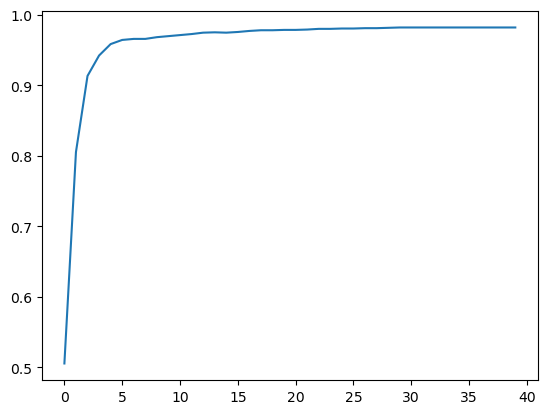

In [9]:
from matplotlib import pyplot as plt
from fastcore.foundation import L

plt.plot(L(learn.recorder.values).itemgot(2));
print(f'final accuracy {learn.recorder.values[-1][2]:.4f}')


In [ ]:
# doesn't work but supposedly yields accuracy near 100%

from fastai.vision.data import ImageDataLoaders
from fastai.vision.learner import vision_learner
from fastai.vision.models import resnet18
import torch.nn.functional as F

dls = ImageDataLoaders.from_folder(path)
learn = vision_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=batch_accuracy)
# learn.fit_one_cycle(1, 0.1) # this doesn't work
learn.fit(1, 0.1)